In [ ]:
import os
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input


#  PARAMETERS

DATASET_PATH = "VGGFace2_balanced_900_albumentations"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 15
EPOCHS = 20
MODEL_SAVE_PATH = "resnet_transfer_best_model.keras"


#  DATA AUGMENTATION

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.02)
])


#  LOAD CLASS NAMES

class_names = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])
class_to_int = {name: i for i, name in enumerate(class_names)}


#PROCESS IMAGE FUNCTION

def process_path(file_path):
    class_name = tf.strings.split(file_path, os.path.sep)[-2]
    label = tf.py_function(lambda x: class_to_int[x.numpy().decode()], [class_name], tf.int32)
    label.set_shape([])
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img, label


# CONFIGURE DATASET PERFORMANCE

def configure_for_performance(ds, shuffle=False):
    ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=3000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


# GET IMAGE PATHS & SPLIT

all_image_paths = [os.path.join(dp, f)
                   for dp, dn, fn in os.walk(os.path.expanduser(DATASET_PATH))
                   for f in fn]
random.shuffle(all_image_paths)  # shuffle before splitting

total_images = len(all_image_paths)
train_size = int(0.7 * total_images)
val_size = int(0.15 * total_images)

train_paths = all_image_paths[:train_size]
val_paths = all_image_paths[train_size:train_size + val_size]
test_paths = all_image_paths[train_size + val_size:]


#  BUILD DATASETS

train_ds = configure_for_performance(
    tf.data.Dataset.from_tensor_slices(train_paths).map(process_path, num_parallel_calls=tf.data.AUTOTUNE),
    shuffle=True
)
val_ds = configure_for_performance(
    tf.data.Dataset.from_tensor_slices(val_paths).map(process_path, num_parallel_calls=tf.data.AUTOTUNE),
    shuffle=False
)
test_ds = configure_for_performance(
    tf.data.Dataset.from_tensor_slices(test_paths).map(process_path, num_parallel_calls=tf.data.AUTOTUNE),
    shuffle=False
)


#BUILD MODEL

base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = layers.Lambda(preprocess_input)(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


#  CALLBACKS

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, min_lr=1e-7, verbose=1)
checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,116,111 (92.00 MB)

 Trainable params: 528,399 (2.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


model.save_weights("resnet_transfer_weights.weights.h5")


Epoch 1/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1967 - loss: 2.4171
Epoch 1: val_accuracy improved from None to 0.53185, saving model to resnet_transfer_best_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 803s 3s/step - accuracy: 0.2899 - loss: 2.0631 - val_accuracy: 0.5319 - val_loss: 1.4426 - learning_rate: 1.0000e-04
Epoch 2/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4931 - loss: 1.4815
Epoch 2: val_accuracy improved from 0.53185 to 0.65383, saving model to resnet_transfer_best_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 561s 2s/step - accuracy: 0.5225 - loss: 1.3927 - val_accuracy: 0.6538 - val_loss: 1.1075 - learning_rate: 1.0000e-04
Epoch 3/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6021 - loss: 1.1741
Epoch 3: val_accuracy improved from 0.65383 to 0.72148, saving model to resnet_transfer_best_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 529s 2s/step - accuracy: 0.6234 - loss: 1.1258 - val_accuracy: 0.7215 - val_loss: 0.9221 - learning_rate: 1.0000

In [7]:

model.save("resnet_transfer_full_model.keras")


64/64 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8365 - loss: 0.5119
Test Accuracy: 83.65%
Test Loss: 0.5119
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━

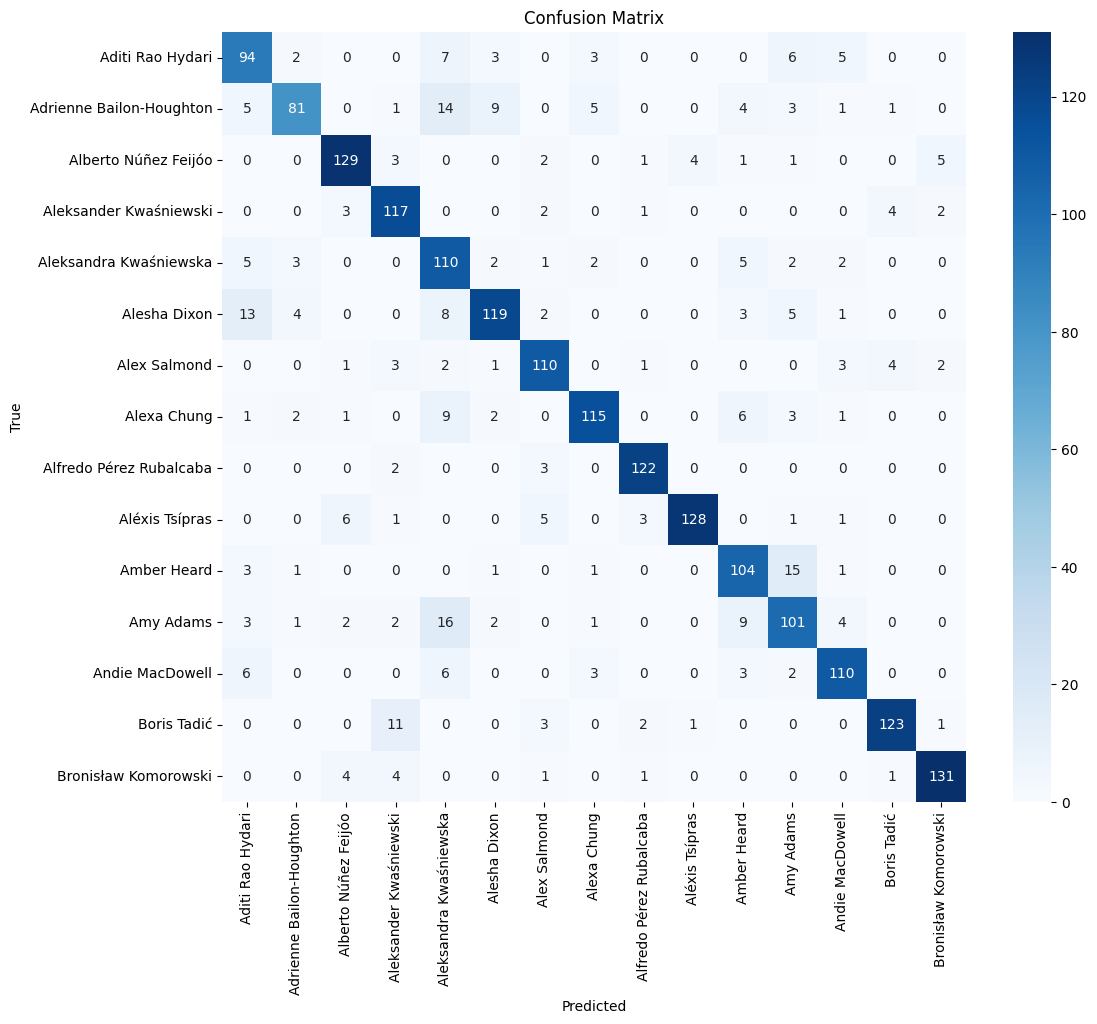

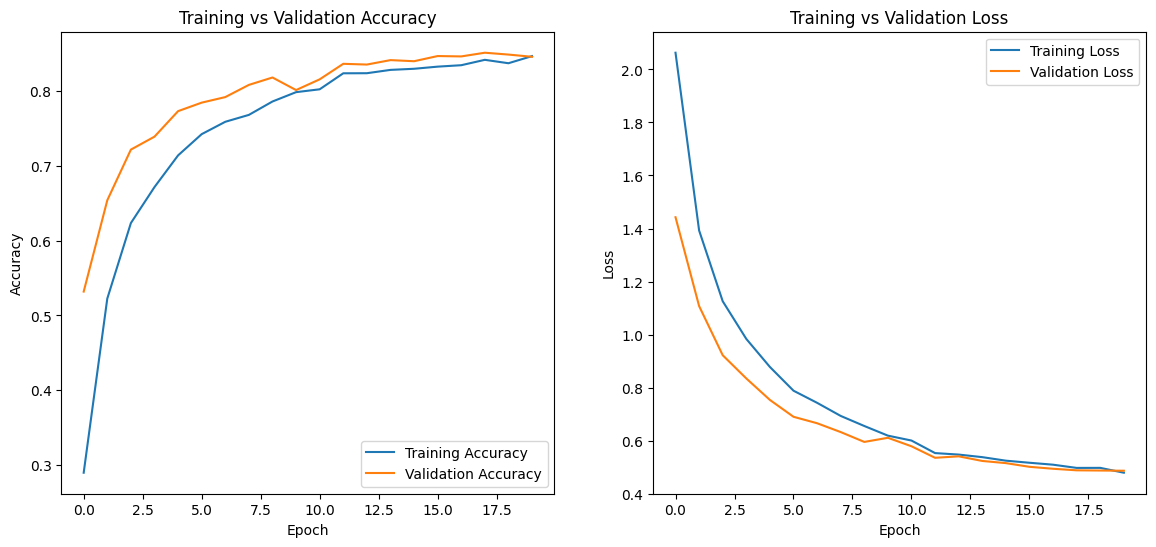

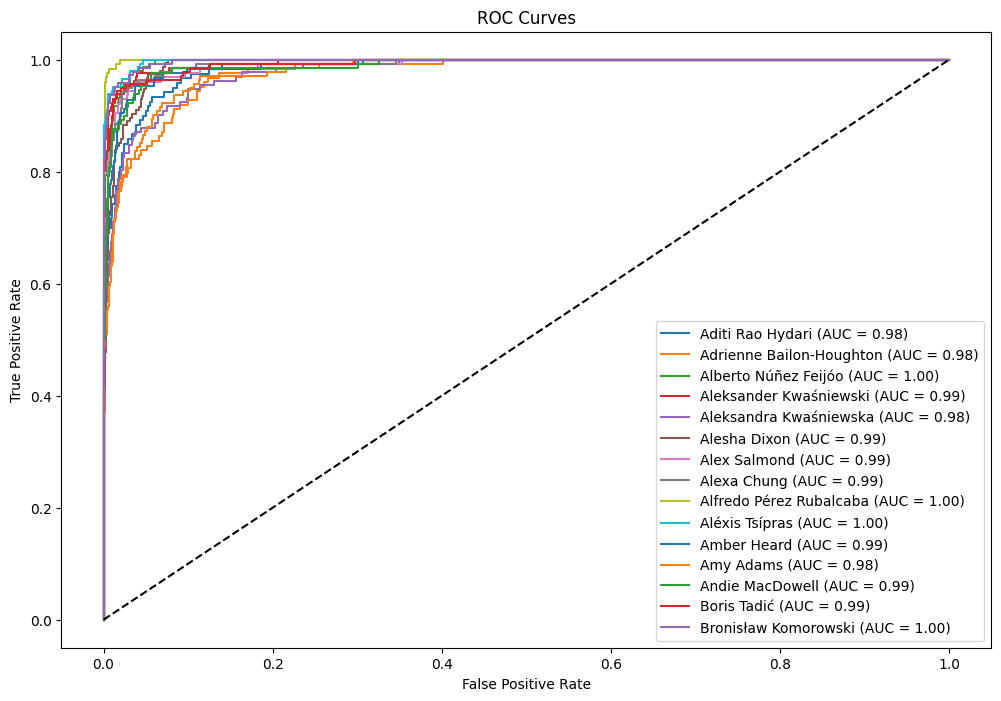

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_recall_fscore_support, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import tensorflow as tf

# Evaluate on Test Set 
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


y_true = []
y_pred = []
y_prob = []

for images, labels in test_ds:
    probs = model.predict(images)
    preds = np.argmax(probs, axis=1)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(preds.tolist())
    y_prob.extend(probs.tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

#  Accuracy, Precision, Recall, F1-score 
acc = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f"Overall Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}\n")


print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#  Training vs Validation Curves 
acc_train = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss_train = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc_train))

plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_train, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_train, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
plt.figure(figsize=(12, 8))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()
